In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [3]:
predictions_dict = {}

In [4]:
config_filename = 'default.yaml'
config = read_config(config_filename)

In [5]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
pulling from source
splitting data ..
splitting data ..
          date      state district  total  active  recovered  deceased  \
0   2020-04-26  Jharkhand   Bokaro     10       5          4         1   
1   2020-04-27  Jharkhand   Bokaro     10       5          4         1   
2   2020-04-28  Jharkhand   Bokaro     10       5          4         1   
3   2020-04-29  Jharkhand   Bokaro     10       5          4         1   
4   2020-04-30  Jharkhand   Bokaro     10       5          4         1   
..         ...        ...      ...    ...     ...        ...       ...   
181 2020-10-24  Jharkhand   Bokaro   5133     363       4725        45   
182 2020-10-25  Jharkhand   Bokaro   5182     377       4760        45   
183 2020-10-26  Jharkhand   Bokaro   5209     339       4825        45   
184 2020-10-27  Jharkhand   Bokaro   5237     337       4854        46   
185 2020-10-28  Jharkhand   Bokaro   5237     337       4854        46   

      tested  other  daily_cases  

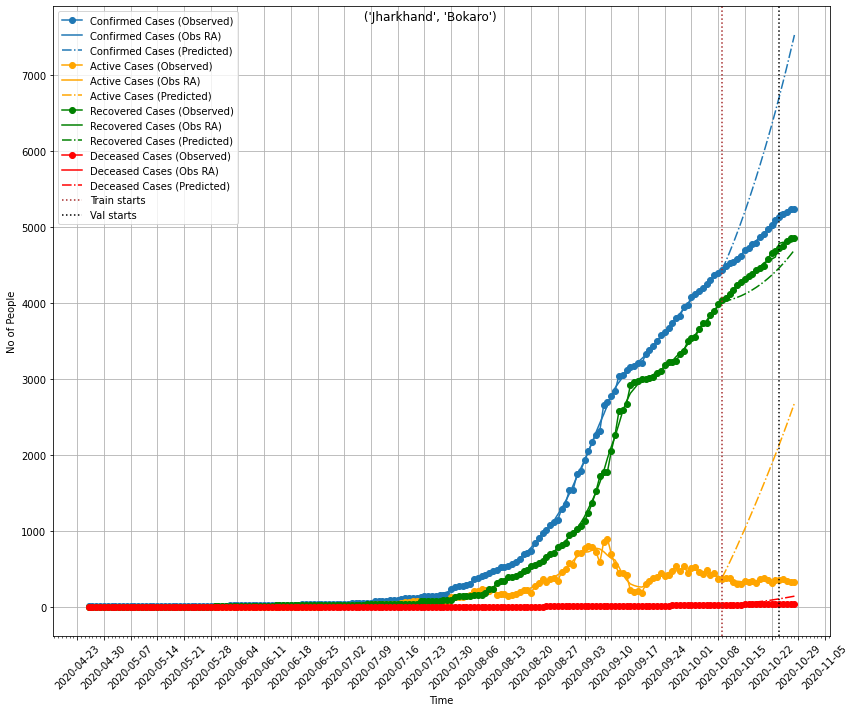

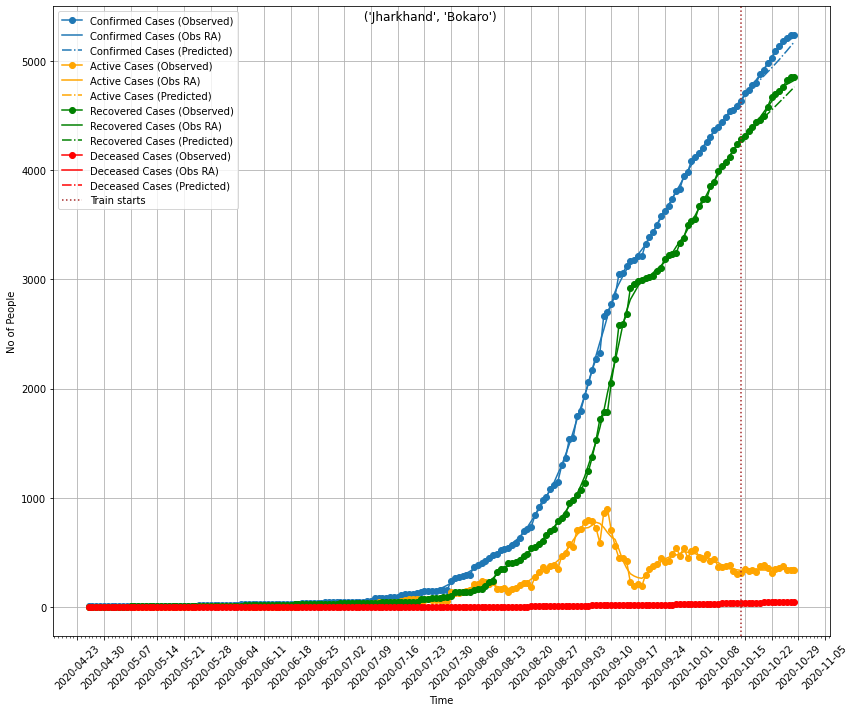

In [6]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)
# predictions_dict['m2'] = predictions_dict['m1']

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [7]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 1.7788039085488017,
 'I_hosp_ratio': 0.8483206754881378,
 'P_fatal': 0.0695226370983687,
 'T_inc': 4.85036755436533,
 'T_inf': 3.093017474475662,
 'T_recov': 38.92132564459717,
 'T_recov_fatal': 13.331826087865734,
 'lockdown_R0': 1.2782688914229186}

In [8]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.28470574939806165,
 'I_hosp_ratio': 0.43067785674979625,
 'P_fatal': 0.05593453534276192,
 'T_inc': 4.742986251804068,
 'T_inf': 3.1979457384609207,
 'T_recov': 9.09452179890948,
 'T_recov_fatal': 24.87240884804187,
 'lockdown_R0': 1.2384774172482191}

## Loss Dataframes

In [9]:
predictions_dict['m2']['df_data_weights_train'][-13:]

date      state district  total  active  recovered  deceased  \
173 2020-10-16  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   
174 2020-10-17  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   
175 2020-10-18  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   
176 2020-10-19  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   
177 2020-10-20  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   
178 2020-10-21  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   
179 2020-10-22  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   
180 2020-10-23  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   
181 2020-10-24  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   
182 2020-10-25  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   
183 2020-10-26  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   
184 2020-10-27  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   
185 2020-10-28  Jharkhand   Bokaro    1.0     1.0        1.0       1.0   

      tested  other  daily_cases  
173  11798.0    NaN         30.0  
174  11798.0    NaN         44.0  
175  11798.0    NaN         23.0  
176  11798.0    NaN         77.0  
177  11798.0    NaN         42.0  
178  11798.0    NaN         61.0  
179  11798.0    NaN         48.0  
180  11798.0    NaN         65.0  
181  11798.0    NaN         40.0  
182  11798.0    NaN         49.0  
183  11798.0    NaN         27.0  
184  11798.0    NaN         28.0  
185  11798.0    NaN          0.0

### M1 Loss DataFrame

In [10]:
predictions_dict['m1']['df_loss']

train      val
total        70.5097  36.8593
active      -435.201  590.606
recovered  0.0585897  4.62813
deceased    -36.8172  179.952

### M2 Loss DataFrame

In [11]:
predictions_dict['m2']['df_loss']

train
total       1.5205
active     4.83823
recovered  1.82955
deceased   3.78976

## Sensitivity Plot

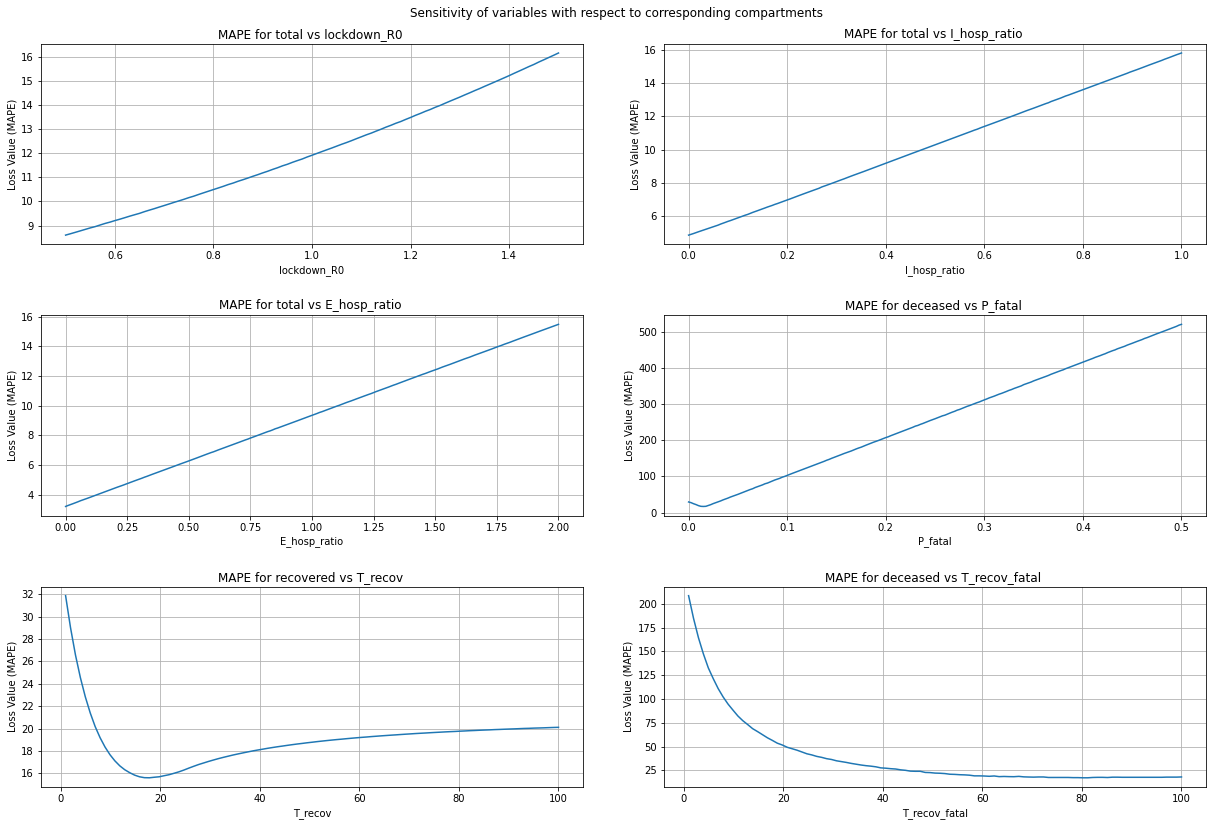

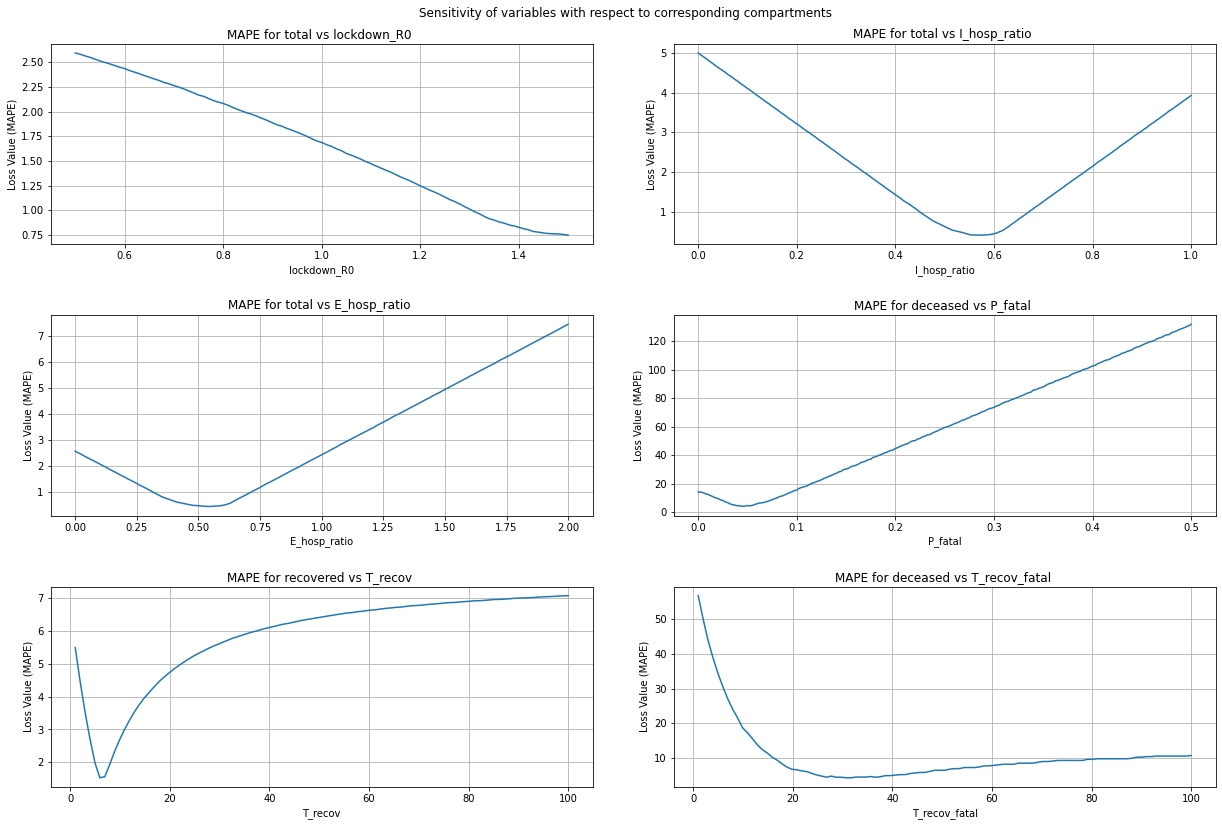

In [12]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [13]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


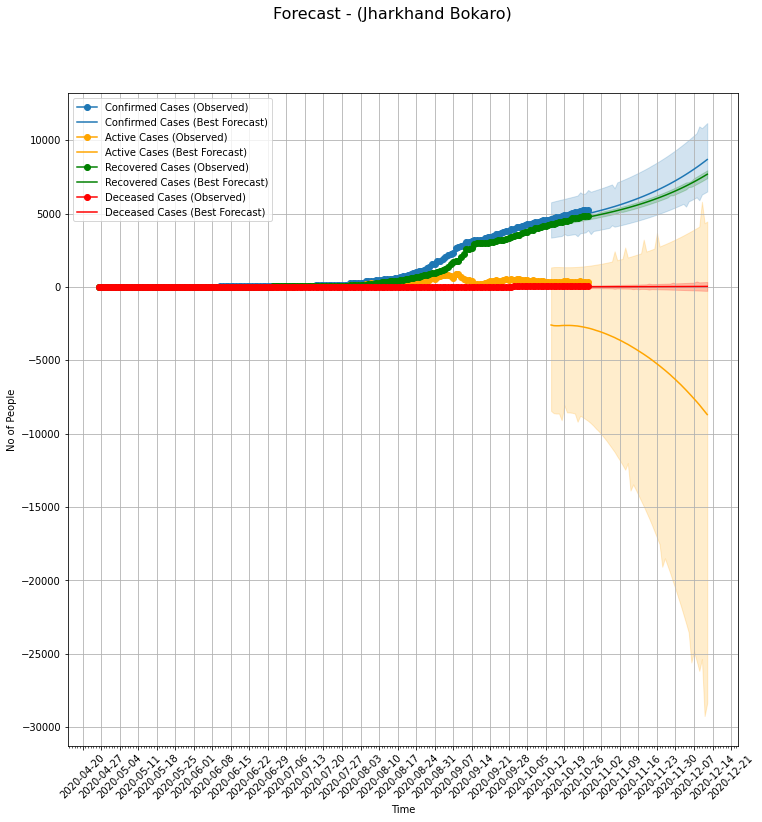

In [14]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [15]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

5it [00:00, 47.33it/s]getting forecasts ..
100it [00:02, 42.85it/s]


In [16]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

4it [00:00, 38.99it/s]getting forecasts ..
100it [00:02, 48.35it/s]


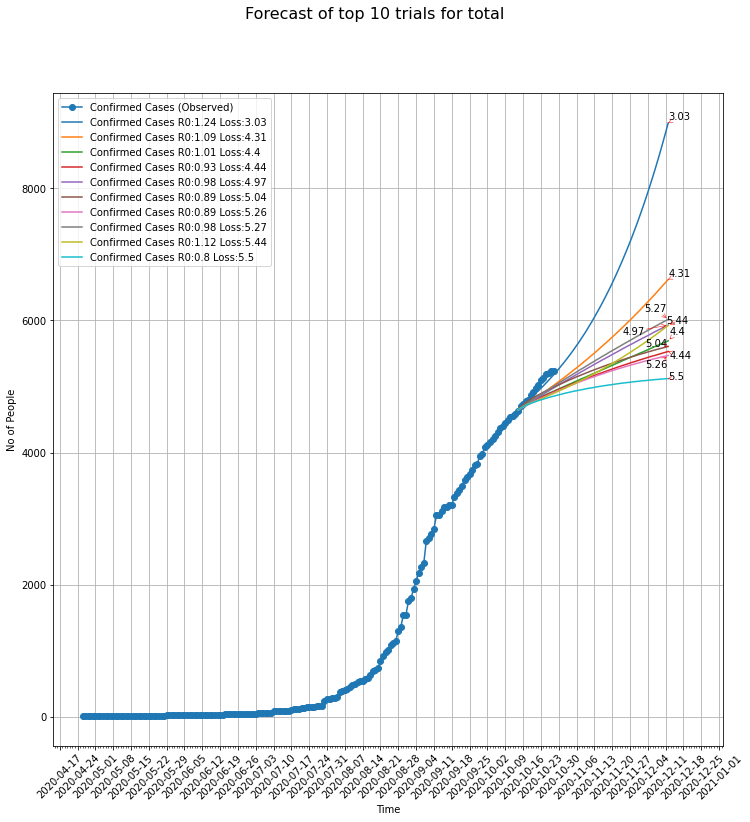

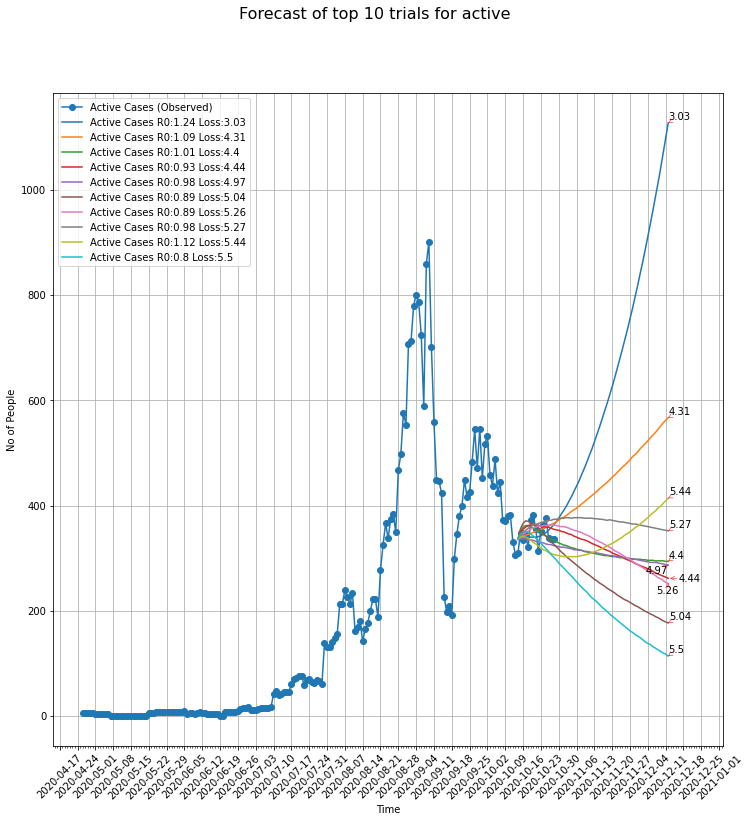

In [17]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [18]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [19]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:09<00:00, 10.24trial/s, best loss: nan]


In [20]:
uncertainty.beta_loss

{'active': 437.07048873754485,
 'recovered': 2.8799466452290994,
 'deceased': 147.3410923191479,
 'total': 27.907290276339825}

In [21]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [22]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

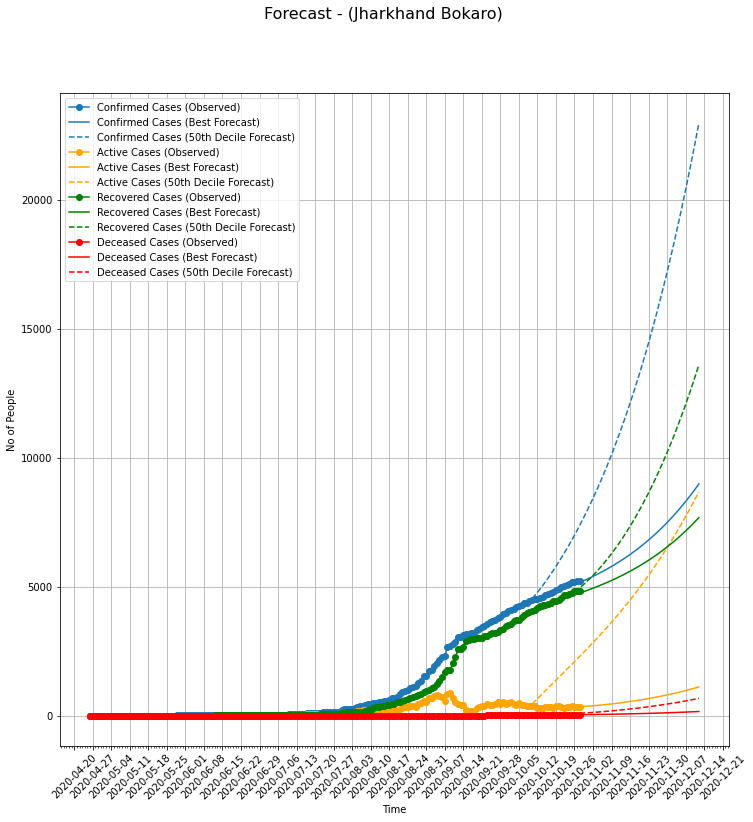

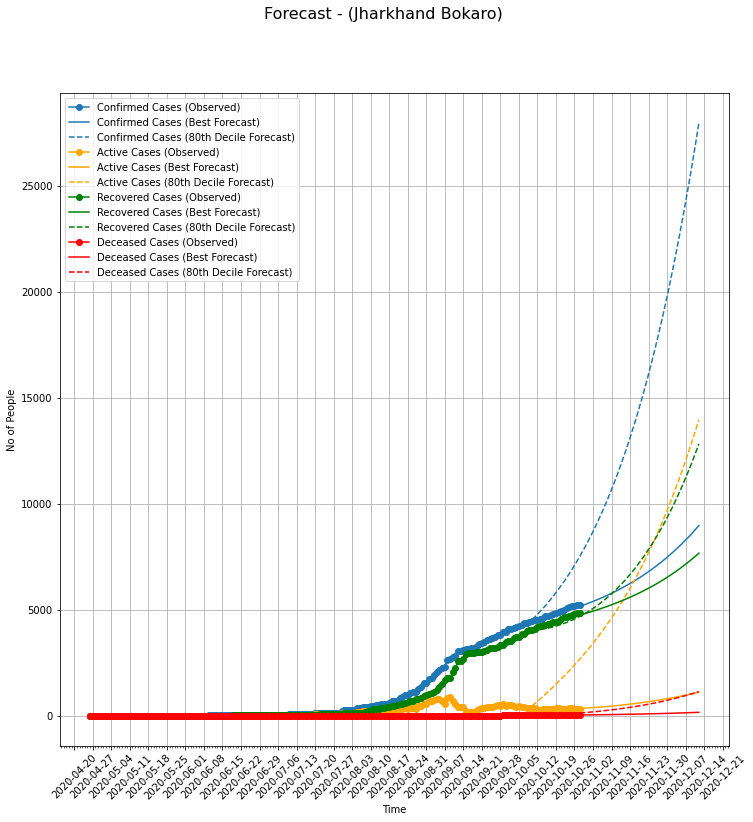

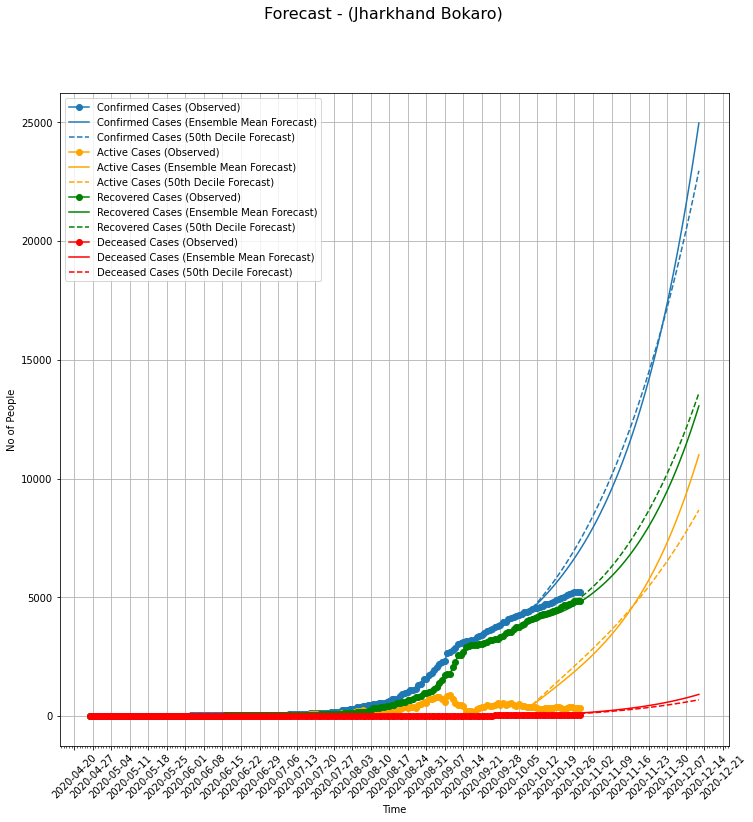

In [23]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

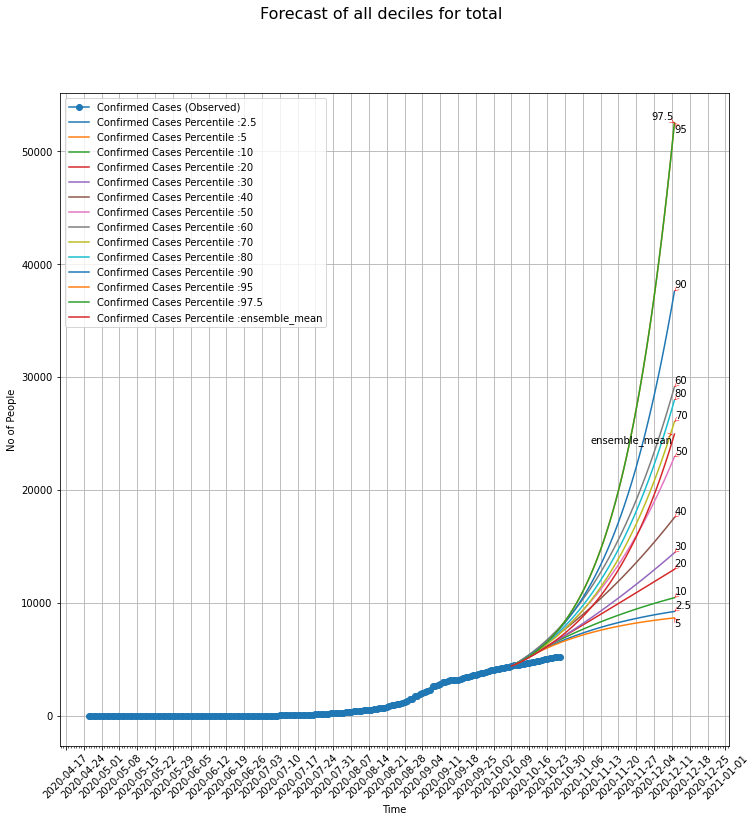

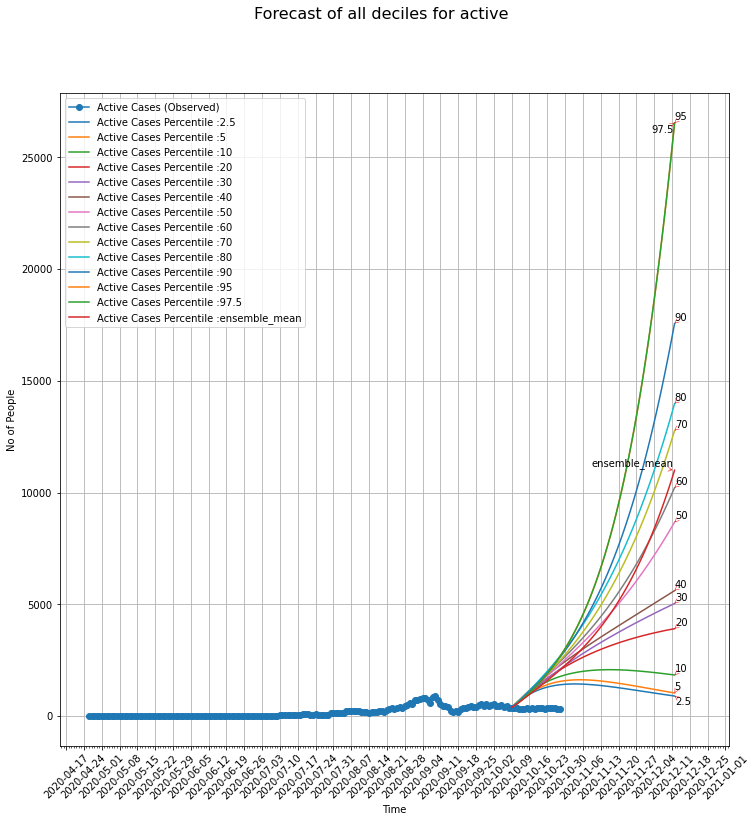

In [24]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


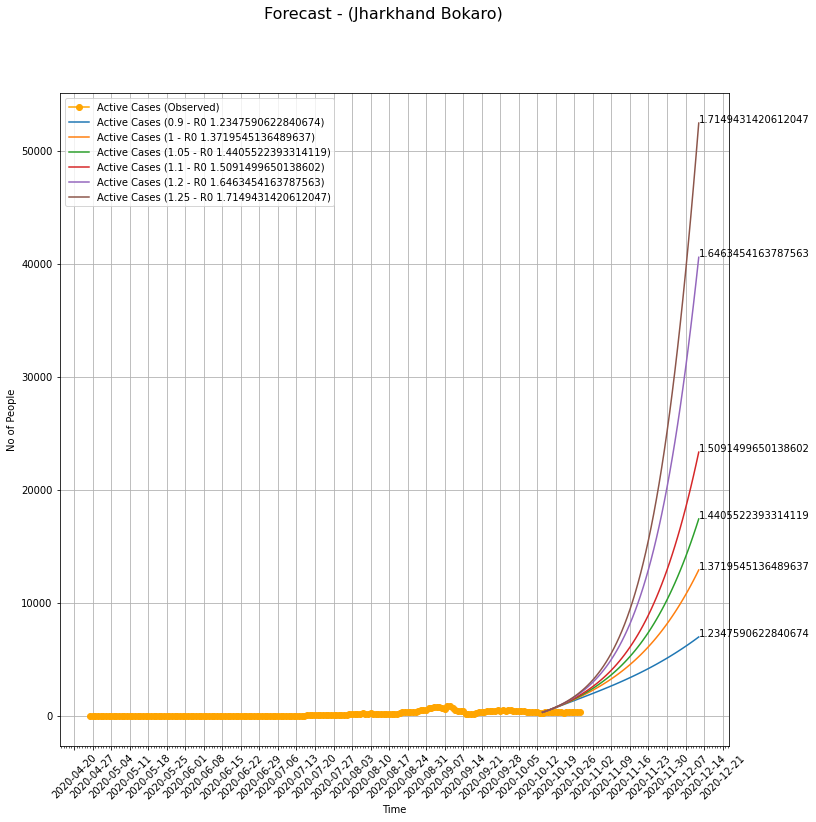

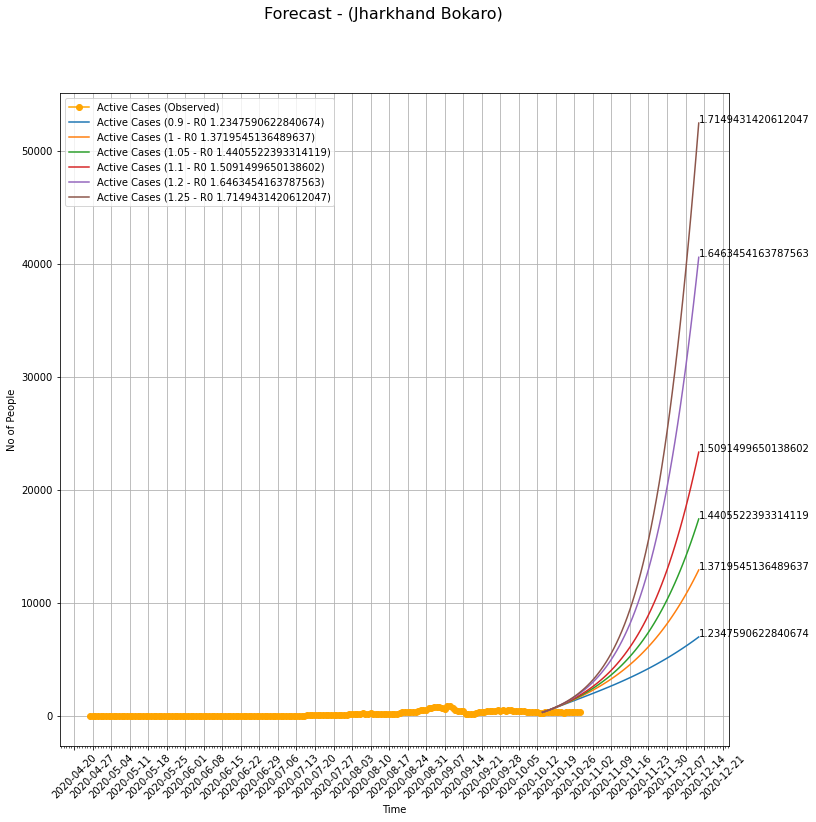

In [25]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_mul_dict = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
plot_r0_multipliers(predictions_dict, None, predictions_mul_dict, None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [26]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [27]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [28]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [29]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Create R0 Multiplier Output

In [30]:
save_r0_mul(predictions_mul_dict, output_folder)

## Create df_district Output

In [31]:
predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')